<a href="https://colab.research.google.com/github/EnterTheBeginning/SmartHomeEnergyForecasting/blob/master/Feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Loading Data

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/1. DataAnalytics/~Code/Data/FmeterClean.csv',index_col='Date & Time',parse_dates=['Date & Time'])


In [0]:
weather = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/1. DataAnalytics/~Code/Data/FweatherClean.csv',index_col='time')


###Lets split the dataset into months

In [0]:
b = np.array_split(df, 12)

In [6]:
b[11].shape

(41820, 23)

In [0]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


### Resample to Every Hour

In [8]:
print('Original ', df.shape )
df_resample = df.resample('h').mean() 
print('Resample ' ,df_resample.shape)



Original  (501847, 23)
Resample  (8784, 23)


### Preprocess


In [17]:
print('Original ', b[11].shape )
m12h = b[11].resample('h').mean() 
print('Resample ' ,m12h.shape)


Original  (41820, 23)
Resample  (697, 23)


Lets have the first 20 days as our Training data  
and last 10 days of month for test  
For the ease of model We just use the Total energy consumption at first

In [0]:
split = 24*20
X = m12h
X_train = m12h.iloc[:split,4:-2].values
y_train = m12h.iloc[:split,0].values
#Test
X_test = m12h.iloc[split:,4:-2].values
y_test = m12h.iloc[split:,0].values
#X = pd.date_range(start='12/1/16', end='12/30/16',freq='h')


#X= m12h.iloc[:,0].values
#y= m12h.iloc[:,0].values
y_train = m12h.iloc[:split,0].values
y_test = m12h.iloc[split:,0].values

In [0]:
split = 24*20
#Train
training_set = m12h.iloc[:split,0:1].values
test_set = m12h.iloc[split:,0:1].values


In [0]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
test_set_scaled = sc.fit_transform(test_set)

###First feature: Time. 

In [0]:
X_train = []
y_train = []
for i in range(24,480):
    X_train.append(training_set_scaled[i-24:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test = []
y_test = []
for i in range(24,217):
    X_test.append(test_set_scaled[i-24:i,0])
    y_test.append(test_set_scaled[i,0])

X_test, y_test = np.array(X_test), np.array(y_test)


In [0]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1]))

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model

from keras.models import Sequential
from keras.layers import Dense, Activation,Flatten
from keras.layers import  Conv1D, MaxPool1D, Dense, Activation, GlobalMaxPool1D
from keras.utils import np_utils
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout




Using TensorFlow backend.


#LSTM

LSTM with 100 neurons in the first visible layer
The final output is the Energy usage 
Start

##LSTM Data Preparation

Scaling:

In [0]:
split = 24*20
#Train
X_train = m12h.iloc[:split,4:-2].values
y_train = m12h.iloc[:split,0].values
#Test
X_test = m12h.iloc[split:,4:-2].values
y_test = m12h.iloc[split:,0].values


In [30]:
print('y_test:', y_test.shape)
print('X_train:' , X_train.shape)


y_test: (217,)
X_train: (480, 17)


In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


##Model:

In [32]:
X_train.shape

(480, 17, 1)

In [0]:
model = Sequential()
layers = [1, 50,100, 1]


In [34]:
model.add(LSTM(layers[1],input_shape=(None, layers[0]),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(layers[2],return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(layers[3]))
model.add(Activation("linear"))
model.compile(loss="mse", optimizer="rmsprop",metrics=['accuracy'])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 50)          10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________________________________________________________________


In [0]:
epochs = 10


In [37]:
model.fit(X_train, y_train,batch_size=16, nb_epoch=epochs, validation_split=0.05)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 456 samples, validate on 24 samples
Epoch 1/10
456/456 [==============================] - 2s 4ms/step - loss: 1.7154 - acc: 0.0000e+00 - val_loss: 2.4487 - val_acc: 0.0000e+00
Epoch 2/10
456/456 [==============================] - 1s 2ms/step - loss: 1.2521 - acc: 0.0000e+00 - val_loss: 2.4033 - val_acc: 0.0000e+00
Epoch 3/10
456/456 [==============================] - 1s 2ms/step - loss: 1.2375 - acc: 0.0000e+00 - val_loss: 2.4933 - val_acc: 0.0000e+00
Epoch 4/10
456/456 [==============================] - 1s 1ms/step - loss: 1.1731 - acc: 0.0000e+00 - val_loss: 1.8438 - val_acc: 0.0000e+00
Epoch 5/10
456/456 [==============================] - 1s 2ms/step - loss: 1.1616 - acc: 0.0000e+00 - val_loss: 2.3013 - val_acc: 0.0000e+00
Epoch 6/10
456/456 [==============================] - 1s 2ms/step - loss: 1.0889 - acc: 0.0000e+00 - val_loss: 2.1253 - val_acc: 0.0000e+00
Epoch 7/10
456/456 [==============================] - 1s 2ms/step - loss: 1.0479 - acc: 0.0000e+00 - val_loss: 1.84

In [38]:
prediction = model.predict(X_test)
score = model.evaluate(X_test,y_test,verbose =0)
print('Test Loss:', score[0])
print('Test accuracy:' , score[1])


Test Loss: 0.7602070916083551
Test accuracy: 0.0


###Graph

Text(0.5, 0, 'Next 200 Hours')

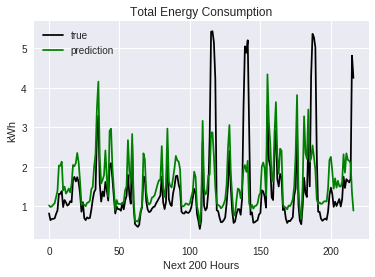

In [39]:
plt.figure(1)
plt.plot(y_test,label='true',color = 'black')
plt.plot(prediction,label='prediction',color = 'green')
plt.legend(loc='upper left')
plt.title('Total Energy Consumption')
plt.ylabel('kWh') 
plt.xlabel('Next 200 Hours')

Since the goal of this research is about prediction under uncertainty.  

In [0]:
split = 24*20
#Train
X_train = m12h.iloc[:split,1:15].values
y_train = m12h.iloc[:split,0].values
#Test
X_test = m12h.iloc[split:,1:15].values
y_test = m12h.iloc[split:,0].values


In [41]:
weather.shape

(8760, 13)

In [42]:
X_train.shape[0]

480

In [0]:
X_train_Weather = weather[-X_train.shape[0]:]
split = 24*20
#Train
X_train = m12h.iloc[:split,1:].values
y_train = m12h.iloc[:split,0].values
#Test
X_test = m12h.iloc[split:,1:].values
y_test = m12h.iloc[split:,0].values


## Pure time series model: No features

This would be our base model. Without any features at first. There will be only the one input layer containing the last hour Energy Consumption   
And the goal of this model is to predict the following 10 days energy consumption solely based on the time

We will not 

In [0]:
split = 24*20
#Train
training_set = m12h.iloc[:split,1:2].values
test_set = m12h.iloc[split:,1:2].values


In [0]:
training_set[0]

array([0.00958722])

Lets see what it looks like:

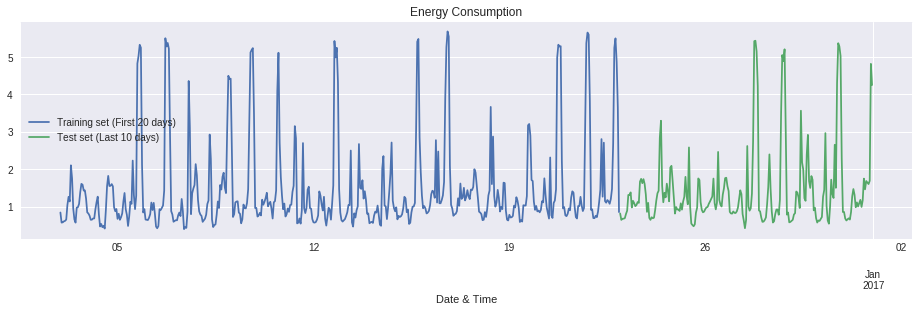

In [0]:
m12h["Usage [kW]"][:split].plot(figsize=(16,4),legend=True)
m12h["Usage [kW]"][split:].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (First 20 days)','Test set (Last 10 days)'])
plt.title('Energy Consumption')
plt.show()

In [0]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output   
So for each element of training set, we have 60 previous training set elements 


In [0]:
X_train = []
y_train = []
for i in range(80,480):
    X_train.append(training_set_scaled[i-80:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [0]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [0]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=8,batch_size=32)

Epoch 1/8
400/400 [==============================] - 5s 13ms/step - loss: 0.0609
Epoch 2/8
400/400 [==============================] - 3s 6ms/step - loss: 0.0528
Epoch 3/8
400/400 [==============================] - 3s 6ms/step - loss: 0.0486
Epoch 4/8
400/400 [==============================] - 3s 6ms/step - loss: 0.0461
Epoch 5/8
400/400 [==============================] - 3s 6ms/step - loss: 0.0429
Epoch 6/8
400/400 [==============================] - 3s 6ms/step - loss: 0.0436
Epoch 7/8
400/400 [==============================] - 3s 6ms/step - loss: 0.0401
Epoch 8/8
400/400 [==============================] - 3s 6ms/step - loss: 0.0391


In [0]:
dataset_total = pd.concat((m12h["Usage [kW]"][:split],m12h["Usage [kW]"][split:]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 80:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)


In [0]:
X_test = []
for i in range(80,278):
    X_test.append(inputs[i-80:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

Text(0.5, 0, 'Next 200 Hours')

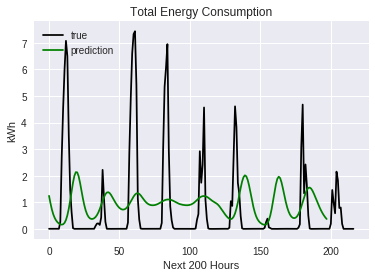

In [0]:
plt.figure(1)
plt.plot(test_set,label='true',color = 'black')
plt.plot(predicted_stock_price,label='prediction',color = 'green')
plt.legend(loc='upper left')
plt.title('Total Energy Consumption')
plt.ylabel('kWh') 
plt.xlabel('Next 200 Hours')

###Graph

In [0]:
dataset_total = pd.concat((m12h["Usage [kW]"][:split],m12h["Usage [kW]"][split:]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 80:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)


In [0]:
X_test = []
for i in range(80,278):
    X_test.append(inputs[i-80:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

Text(0.5, 0, 'Next 200 Hours')

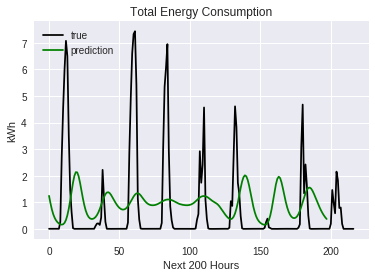

In [0]:
plt.figure(1)
plt.plot(test_set,label='true',color = 'black')
plt.plot(predicted_stock_price,label='prediction',color = 'green')
plt.legend(loc='upper left')
plt.title('Total Energy Consumption')
plt.ylabel('kWh') 
plt.xlabel('Next 200 Hours')

# DNN:

In [23]:
model = Sequential()
model.add(Dense(output_dim = 20, init = 'uniform', activation = 'relu', input_dim = 24))
model.add(Dense(output_dim = 35, init = 'uniform', activation = 'relu'))
model.add(Dense(output_dim = 1, init = 'uniform', activation = 'linear'))

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=24, units=20, kernel_initializer="uniform")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=35, kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="linear", units=1, kernel_initializer="uniform")`
  after removing the cwd from sys.path.


In [0]:
model.compile(optimizer = 'adam', loss = 'mean_absolute_error', metrics = ['mean_absolute_error'])


In [25]:
model.fit(X_train, y_train, batch_size = 6, nb_epoch = 10, shuffle=0)


Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Epoch 1/10
456/456 [==============================] - 1s 1ms/step - loss: 0.1439 - mean_absolute_error: 0.1439
Epoch 2/10
456/456 [==============================] - 0s 201us/step - loss: 0.1205 - mean_absolute_error: 0.1205
Epoch 3/10
456/456 [==============================] - 0s 213us/step - loss: 0.1117 - mean_absolute_error: 0.1117
Epoch 4/10
456/456 [==============================] - 0s 222us/step - loss: 0.1038 - mean_absolute_error: 0.1038
Epoch 5/10
456/456 [==============================] - 0s 218us/step - loss: 0.0995 - mean_absolute_error: 0.0995
Epoch 6/10
456/456 [==============================] - 0s 217us/step - loss: 0.0952 - mean_absolute_error: 0.0952
Epoch 7/10
456/456 [==============================] - 0s 216us/step - loss: 0.0907 - mean_absolute_error: 0.0907
Epoch 8/10
456/456 [==============================] - 0s 206us/step - loss: 0.0866 - mean_absolute_error: 0.0866
Epoch 9/10
456/456 [==============================] - 0s 199us/step - loss: 0.0832 - mean_absolute

In [26]:
prediction = model.predict(X_test)
score = model.evaluate(X_test,y_test,verbose =0)
print('Test Loss:', score[0])
print('Test accuracy:' , score[1])
prediction = sc.inverse_transform(prediction)


Test Loss: 0.08752291406374521
Test accuracy: 0.08752291406374521


Text(0.5, 0, '120 Hour Prediction  ')

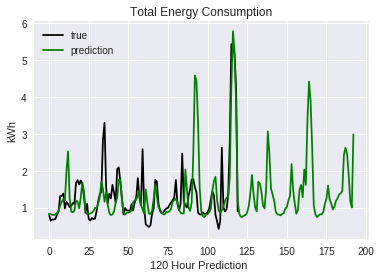

In [27]:
plt.figure(1)
plt.plot(test_set[:120],label='true',color = 'black')
plt.plot(prediction,label='prediction',color = 'green')
plt.legend(loc='upper left')
plt.title('Total Energy Consumption')
plt.ylabel('kWh') 
plt.xlabel('120 Hour Prediction  ')

In [0]:
dataset_total = pd.concat((m12h["Usage [kW]"][:split],m12h["Usage [kW]"][split:]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 80:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)
